In [ ]:
!unzip drive/MyDrive/dataset_zurich.zip

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!rm -rf __MACOSX

In [8]:
!pip install -U xgboost  # Upgrade to be able to access dask.
import xgboost as xgb
# from sklearn.externals.joblib import parallel_backend ## DEPRECATED!

  Using cached xgboost-1.4.2-py3-none-manylinux2010_x86_64.whl (166.7 MB)


In [8]:
!pip install -U imbalanced-learn

     |████████████████████████████████| 206 kB 5.4 MB/s 
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.4.3
    Uninstalling imbalanced-learn-0.4.3:
      Successfully uninstalled imbalanced-learn-0.4.3


In [12]:
import os

import numpy as np
import matplotlib.pyplot as plt

import cv2

# To get latest features of imblearn, needed to restart runtime.
import imblearn
# import dask.dataframe as dd
# import dask.array as da
# import dask_image.imread

In [13]:
def generate_data(category):
  """Combine files from folders and generate a single numpy array.

  category: Which category, train, valid, or test data to create.
  Either of "test", "validation", "training".

  """
  data = []
  labels = []
  root_dir = "dataset_zurich"
  classes = ["merger", "noninteracting"]
  for class_ in classes:
    class_category_path = os.path.join(root_dir, class_, category)
    img_paths = os.listdir(class_category_path)
    for img_path in img_paths:
      img = cv2.imread(os.path.join(class_category_path, img_path))
      img = cv2.resize(img, (100, 100)).mean(axis=2).flatten()
      labels.append(1) if class_ == "merger" else labels.append(0)
      data.append(img)
  return np.array(data), np.array(labels)

In [14]:
train_data, train_labels = generate_data("training")

In [15]:
valid_data, valid_labels = generate_data("validation")

In [16]:
test_data, test_labels = generate_data("test")

In [17]:
from imblearn.over_sampling import SMOTE

In [11]:
smote = SMOTE()
train_data_resampled, train_label_resampled = smote.fit_resample(train_data, train_labels)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Original label distribution

In [75]:
print(Counter(train_labels))

Counter({0: 5000, 1: 3003})


In [21]:
print(f"No. of samples of the class 0: {np.sum(train_label_resampled == 0)}")
print(f"No. of samples of the class 1: {np.sum(train_label_resampled == 1)}")

No. of samples of the class 0: 5000
No. of samples of the class 1: 5000


In [72]:
from collections import Counter
print(Counter(train_label_resampled))

Counter({1: 5000, 0: 5000})


Since there were originally 8003 training samples and there are 10000 samples after SMOTE, the last 1997 images are the ones generated through SMOTE whereas the initial 8003 images remain unchanged. Here, only the minority class was resampled.

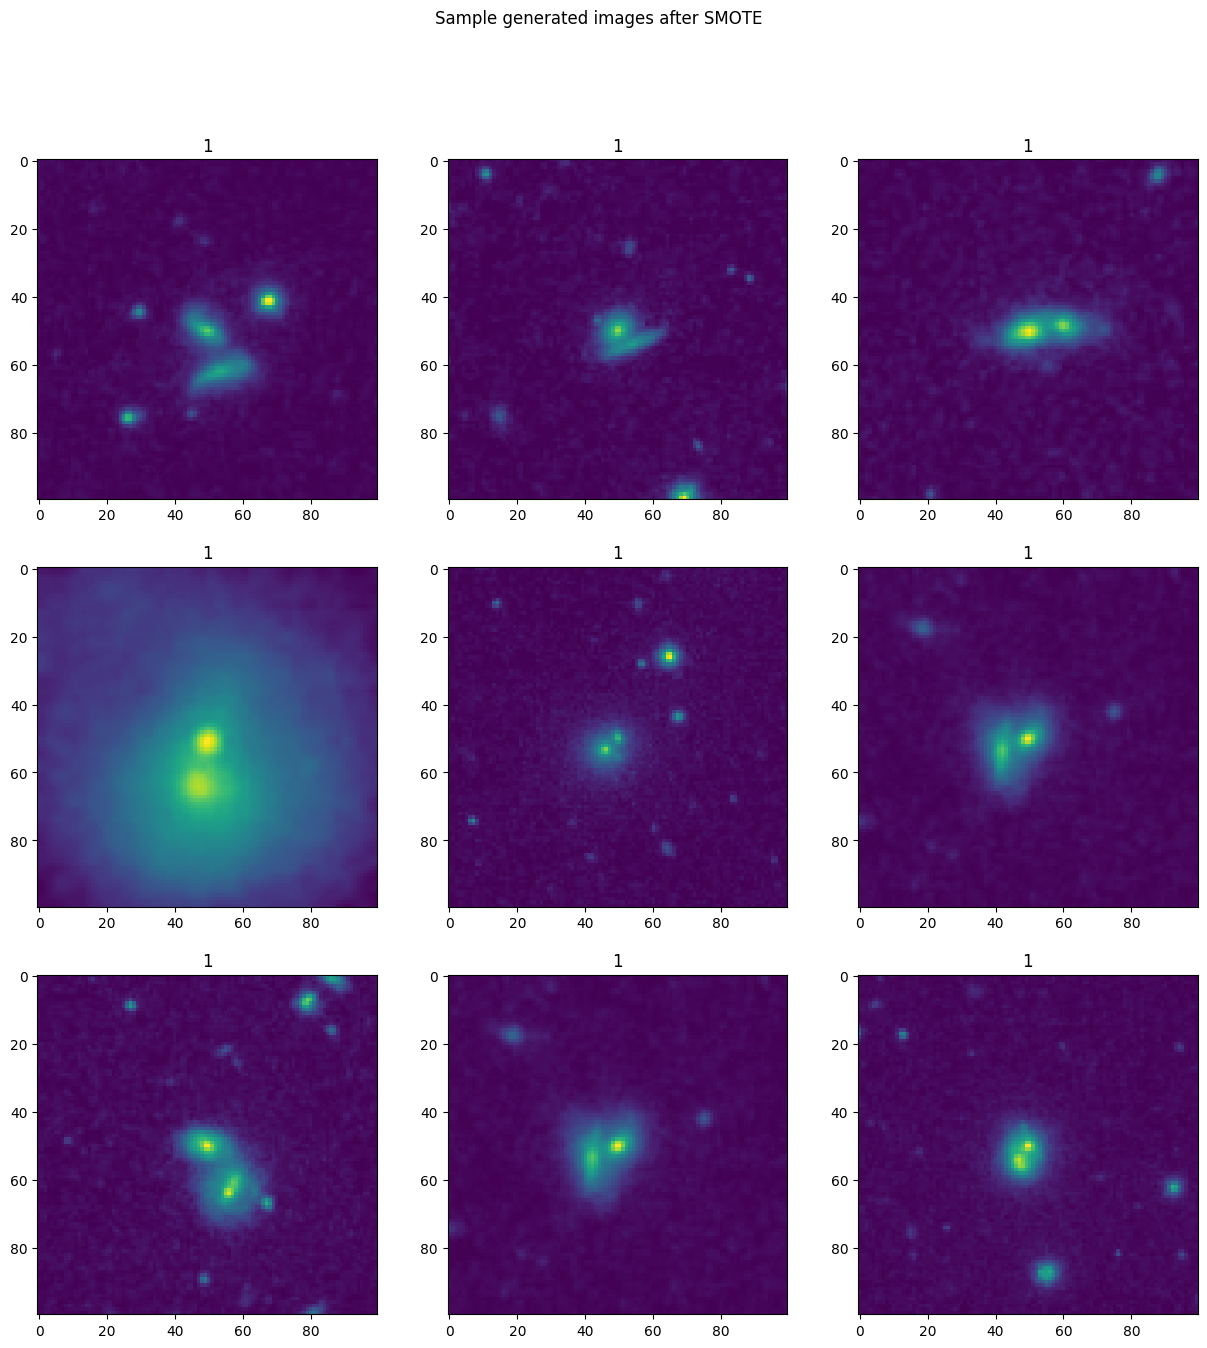

In [69]:
# Plot some images after SMOTE
# "1" means a merger galaxy

smote_indx_start = 8003  # 0-8002 indices correspond to the original images.
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
fig.suptitle("Sample generated images after SMOTE")


axes[0, 0].imshow(train_data_resampled[smote_indx_start+10].reshape(100, 100));
axes[0, 0].set_title(train_label_resampled[smote_indx_start+10]);
axes[0, 1].imshow(train_data_resampled[smote_indx_start+100].reshape(100, 100));
axes[0, 1].set_title(train_label_resampled[smote_indx_start+100]);
axes[0, 2].imshow(train_data_resampled[smote_indx_start+700].reshape(100, 100));
axes[0, 2].set_title(train_label_resampled[smote_indx_start+700]);
axes[1, 0].imshow(train_data_resampled[smote_indx_start+1000].reshape(100, 100));
axes[1, 0].set_title(train_label_resampled[smote_indx_start+1000]);
axes[1, 1].imshow(train_data_resampled[smote_indx_start+1250].reshape(100, 100));
axes[1, 1].set_title(train_label_resampled[smote_indx_start+1250]);
axes[1, 2].imshow(train_data_resampled[smote_indx_start+1750].reshape(100, 100));
axes[1, 2].set_title(train_label_resampled[smote_indx_start+1500]);
axes[2, 0].imshow(train_data_resampled[smote_indx_start+1500].reshape(100, 100));
axes[2, 0].set_title(train_label_resampled[smote_indx_start+1750]);
axes[2, 1].imshow(train_data_resampled[smote_indx_start+1750].reshape(100, 100));
axes[2, 1].set_title(train_label_resampled[smote_indx_start+1750]);
axes[2, 2].imshow(train_data_resampled[smote_indx_start+1900].reshape(100, 100));
axes[2, 2].set_title(train_label_resampled[smote_indx_start+1900]);

In [18]:
import xgboost as xgb

In [ ]:
train = xgb.DMatrix(train_data_resampled, label=train_label_resampled)
valid = xgb.DMatrix(valid_data, label=train_labels)
test = xgb.DMatrix(test_data, label=test_labels)

In [19]:
# Define parameters for XGBoost classifier.
params = {}

# The values have been selected using cross validation on a subset of the data. Analysis in cv_analysis.md.

# Booster parameters
params["eta"]              = 0.01 # Learning rate
params["max_depth"]        = 12  # Maximum depth of tree
params["subsample"]        = 0.8 # Fraction of events to train the tree on
params["colsample_bytree"] = 0.8 # Fraction of features to train the tree on
params["min_child_weight"] = 13 # Minimum weight required to create a new node in the tree

# Learning parameters
params["objective"]   = "binary:logistic" # Objective function (two classes for which a score needs to be output)
params["eval_metric"] = "error"           # Evaluation metric for cross validation
params = dict(list(params.items()) + [("eval_metric", "log-loss"), ("eval_metric", "rmse")])

In [46]:
num_trees = 300
booster = xgb.train(params, train, num_boost_round=num_trees)

In [47]:
model_path = "xgbbost_model.txt"
booster.save_model(fname=model_path)

In [48]:
predictions = booster.predict(test)

In [49]:
predictions

array([0.8460885 , 0.35568953, 0.33093902, ..., 0.57406396, 0.16149329,
       0.1446828 ], dtype=float32)

In [50]:
evaluation = booster.eval(test)
evaluation

'[0]\teval-rmse:0.307325'

In [51]:
def plot_predictions(predictions, test):
  """Plot a histogram of predictions by the model, both combined and class wise.
  Parameters
  ----------
  predictions: ~np.array
    Predictions from the model
  test: ~xgboost.core.DMatrix
    The testing dataset
  Returns
  -------
  Prediction plot
  """
  import matplotlib.pyplot as plt

  fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(30, 10));

  hist_style_all = dict(histtype="step", color="darkgreen", label="All events")
  hist_style_sig = dict(histtype="step", color="midnightblue", label="merger")
  hist_style_bkg = dict(histtype="step", color="firebrick", label="noninteracting")

  ax1.hist(predictions, bins=np.linspace(0, 1, 50), **hist_style_all);

  ax1.set_xlabel("Prediction probabilties", fontsize=16);
  ax1.set_ylabel("No. of instances", fontsize=16);
  ax1.set_title("Combined");
  ax1.legend(frameon=False);

  ax2.hist(predictions[test.get_label().astype(bool)], bins=np.linspace(0, 1, 50),
          **hist_style_sig);
  ax2.hist(predictions[~(test.get_label().astype(bool))], bins=np.linspace(0, 1, 50),
          **hist_style_bkg);

  ax2.set_xlabel("Prediction probabilties", fontsize=16);
  ax2.set_ylabel("No. of instances", fontsize=16);
  ax2.set_title("Individual")
  ax2.legend(frameon=False);


def plot_roc(predictions, test):
  import matplotlib.pyplot as plt
  try:
    from plot_metric.functions import BinaryClassification
  except ImportError:
    raise ValueError("Error while import! Cannot import `BinaryClassification from` `plot_metric.functions`. "
          "Use 'pip install plot-metric' to solve this error.")
  
  # Visualisation with plot_metric
  bc = BinaryClassification(test.get_label(), predictions, labels=["Class 1", "Class 2"])

  # Figures
  plt.figure(figsize=(10,10))
  bc.plot_roc_curve()
  plt.show()

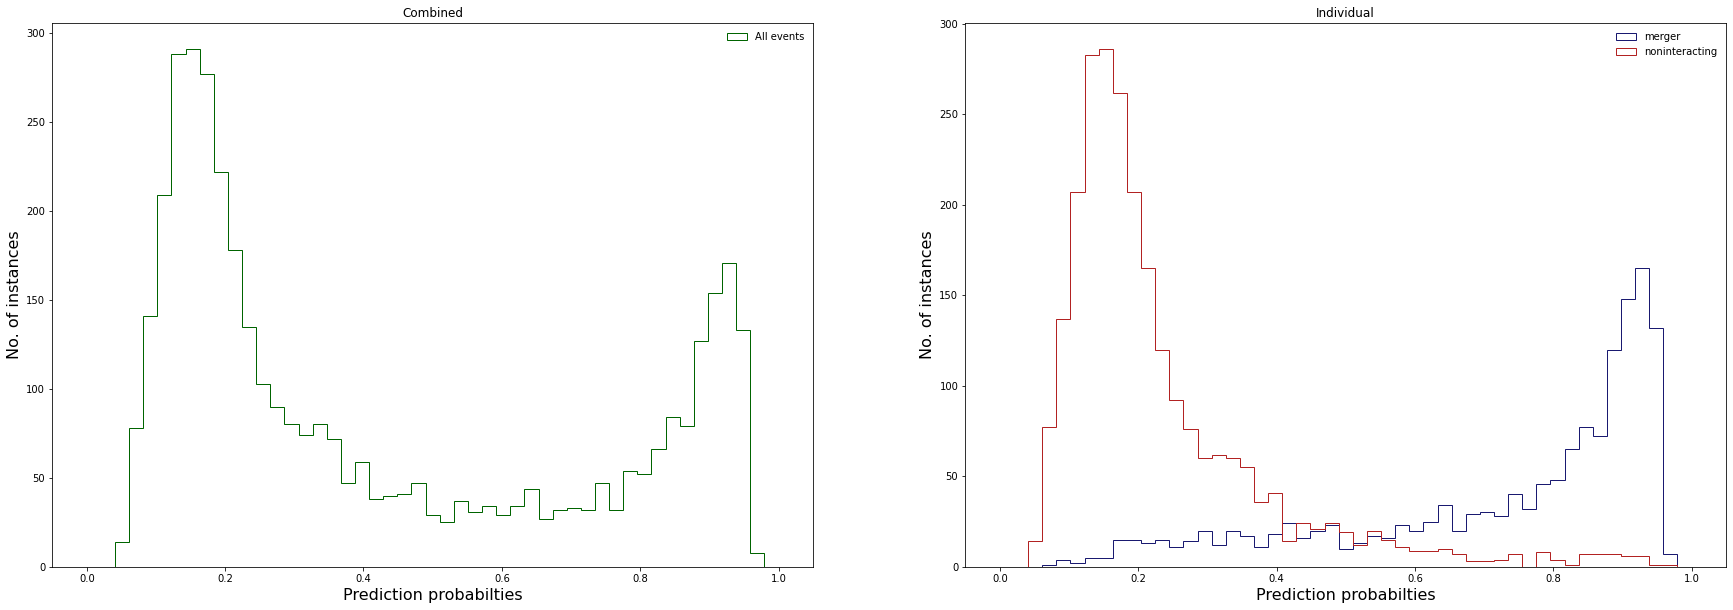

In [52]:
plot_predictions(predictions, test)

In [53]:
!pip install plot-metric

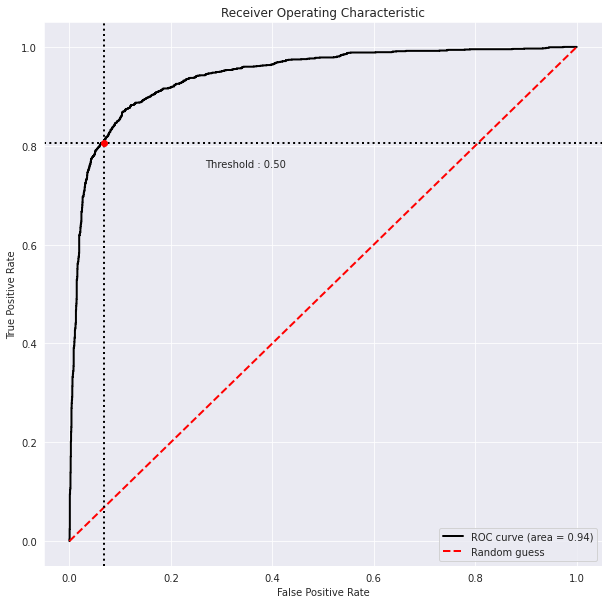

In [54]:
plot_roc(predictions, test)

In [7]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score

In [56]:
final_predictions = np.array([round(pred) for pred in predictions])

In [57]:
confusion_matrix(test.get_label(), final_predictions)

array([[2332,  168],
       [ 290, 1208]])

In [58]:
accuracy_score(test.get_label(), final_predictions)

0.8854427213606804

In [70]:
print(classification_report(test.get_label(), final_predictions))

              precision    recall  f1-score   support

         0.0       0.89      0.93      0.91      2500
         1.0       0.88      0.81      0.84      1498

    accuracy                           0.89      3998
   macro avg       0.88      0.87      0.88      3998
weighted avg       0.89      0.89      0.88      3998



In [73]:
# Using ADASYN
from imblearn.over_sampling import ADASYN

In [74]:
adasyn = ADASYN()
train_data_resampled, train_label_resampled = adasyn.fit_resample(train_data, train_labels)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [76]:
train = xgb.DMatrix(train_data_resampled, label=train_label_resampled)
valid = xgb.DMatrix(valid_data, label=train_labels)
test = xgb.DMatrix(test_data, label=test_labels)

In [77]:
num_trees = 300
booster = xgb.train(params, train, num_boost_round=num_trees)

In [78]:
model_path = "xgbbost_model_adasyn.txt"
booster.save_model(fname=model_path)

In [79]:
predictions = booster.predict(test)

In [80]:
evaluation = booster.eval(test)
evaluation

'[0]\teval-rmse:0.313651'

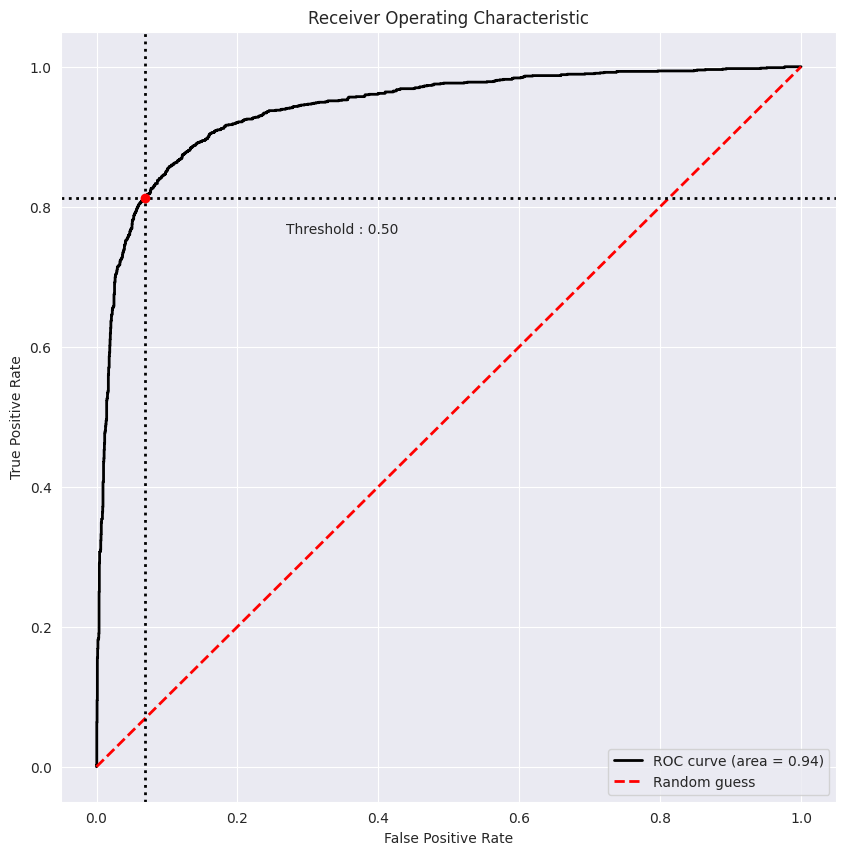

In [81]:
plot_roc(predictions, test)

In [84]:
final_predictions = np.array([round(pred) for pred in predictions])

In [85]:
accuracy_score(test.get_label(), final_predictions)

0.8864432216108054

In [87]:
print(classification_report(test.get_label(), final_predictions))

              precision    recall  f1-score   support

         0.0       0.89      0.93      0.91      2500
         1.0       0.88      0.81      0.84      1498

    accuracy                           0.89      3998
   macro avg       0.88      0.87      0.88      3998
weighted avg       0.89      0.89      0.89      3998



From the original SMOTE paper *(Chawla, Bowyer, Hall & Kegelmeyer, 2002)*:

> This paper shows that a combination of our method of over-sampling
the minority (abnormal) class and under-sampling the majority (normal) class can achieve
better classifier performance (in ROC space) than only under-sampling the majority class

In [23]:
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
over = SMOTE(sampling_strategy=0.8)  # The original ration of minor/major samples was ~0.6.
under = RandomUnderSampler()
steps = [('over', over), ('under', under)]
pipeline = Pipeline(steps=steps)
train_data_resampled, train_label_resampled = pipeline.fit_resample(train_data, train_labels)

In [134]:
train_data_resampled.shape

(8000, 10000)

In [135]:
train_label_resampled.shape

(8000,)

In [136]:
Counter(train_label_resampled)

Counter({0: 4000, 1: 4000})

In [138]:
train = xgb.DMatrix(train_data_resampled, label=train_label_resampled)
num_trees = 300
booster = xgb.train(params, train, num_boost_round=num_trees)

In [139]:
preds = booster.predict(test)

In [140]:
final_preds = np.array([round(pred) for pred in preds])

In [141]:
accuracy_score(test.get_label(), final_preds)

0.8929464732366184

In [142]:
print(classification_report(test.get_label(), final_preds))

              precision    recall  f1-score   support

         0.0       0.90      0.93      0.92      2500
         1.0       0.87      0.83      0.85      1498

    accuracy                           0.89      3998
   macro avg       0.89      0.88      0.88      3998
weighted avg       0.89      0.89      0.89      3998



Exception ignored in: <function Booster.__del__ at 0x7fe278bb2950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/xgboost/core.py", line 957, in __del__
    if self.handle is not None:
AttributeError: 'Booster' object has no attribute 'handle'
Exception ignored in: <function Booster.__del__ at 0x7fe278bb2950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/xgboost/core.py", line 957, in __del__
    if self.handle is not None:
AttributeError: 'Booster' object has no attribute 'handle'


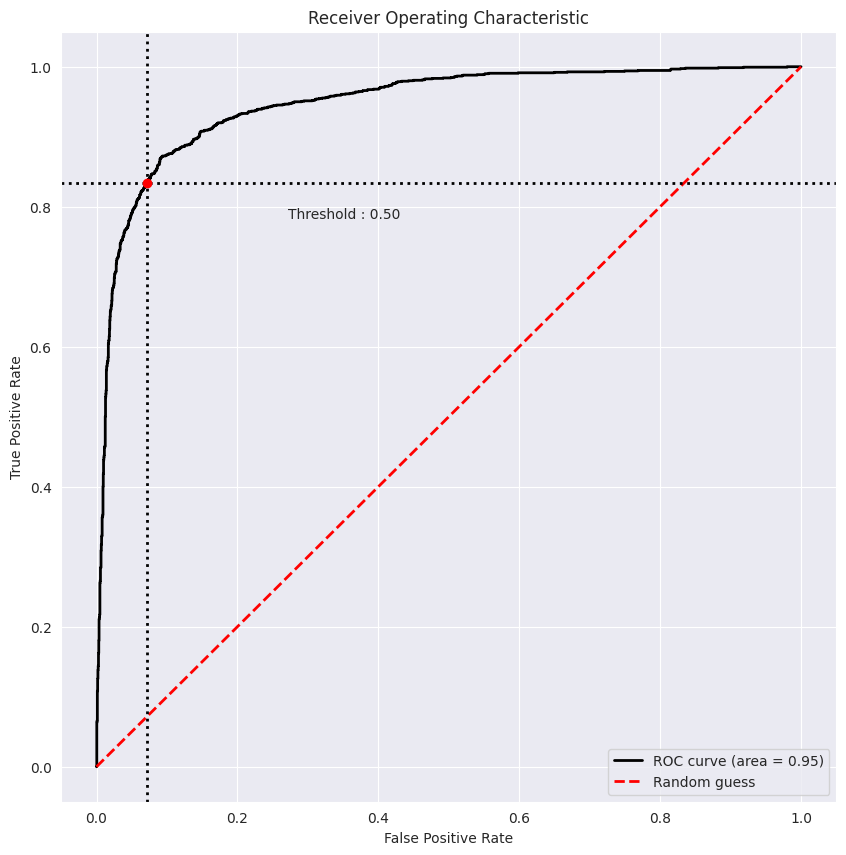

In [144]:
plot_roc(preds, test)

In [145]:
eval = booster.eval(test)
eval

'[0]\teval-rmse:0.302146'

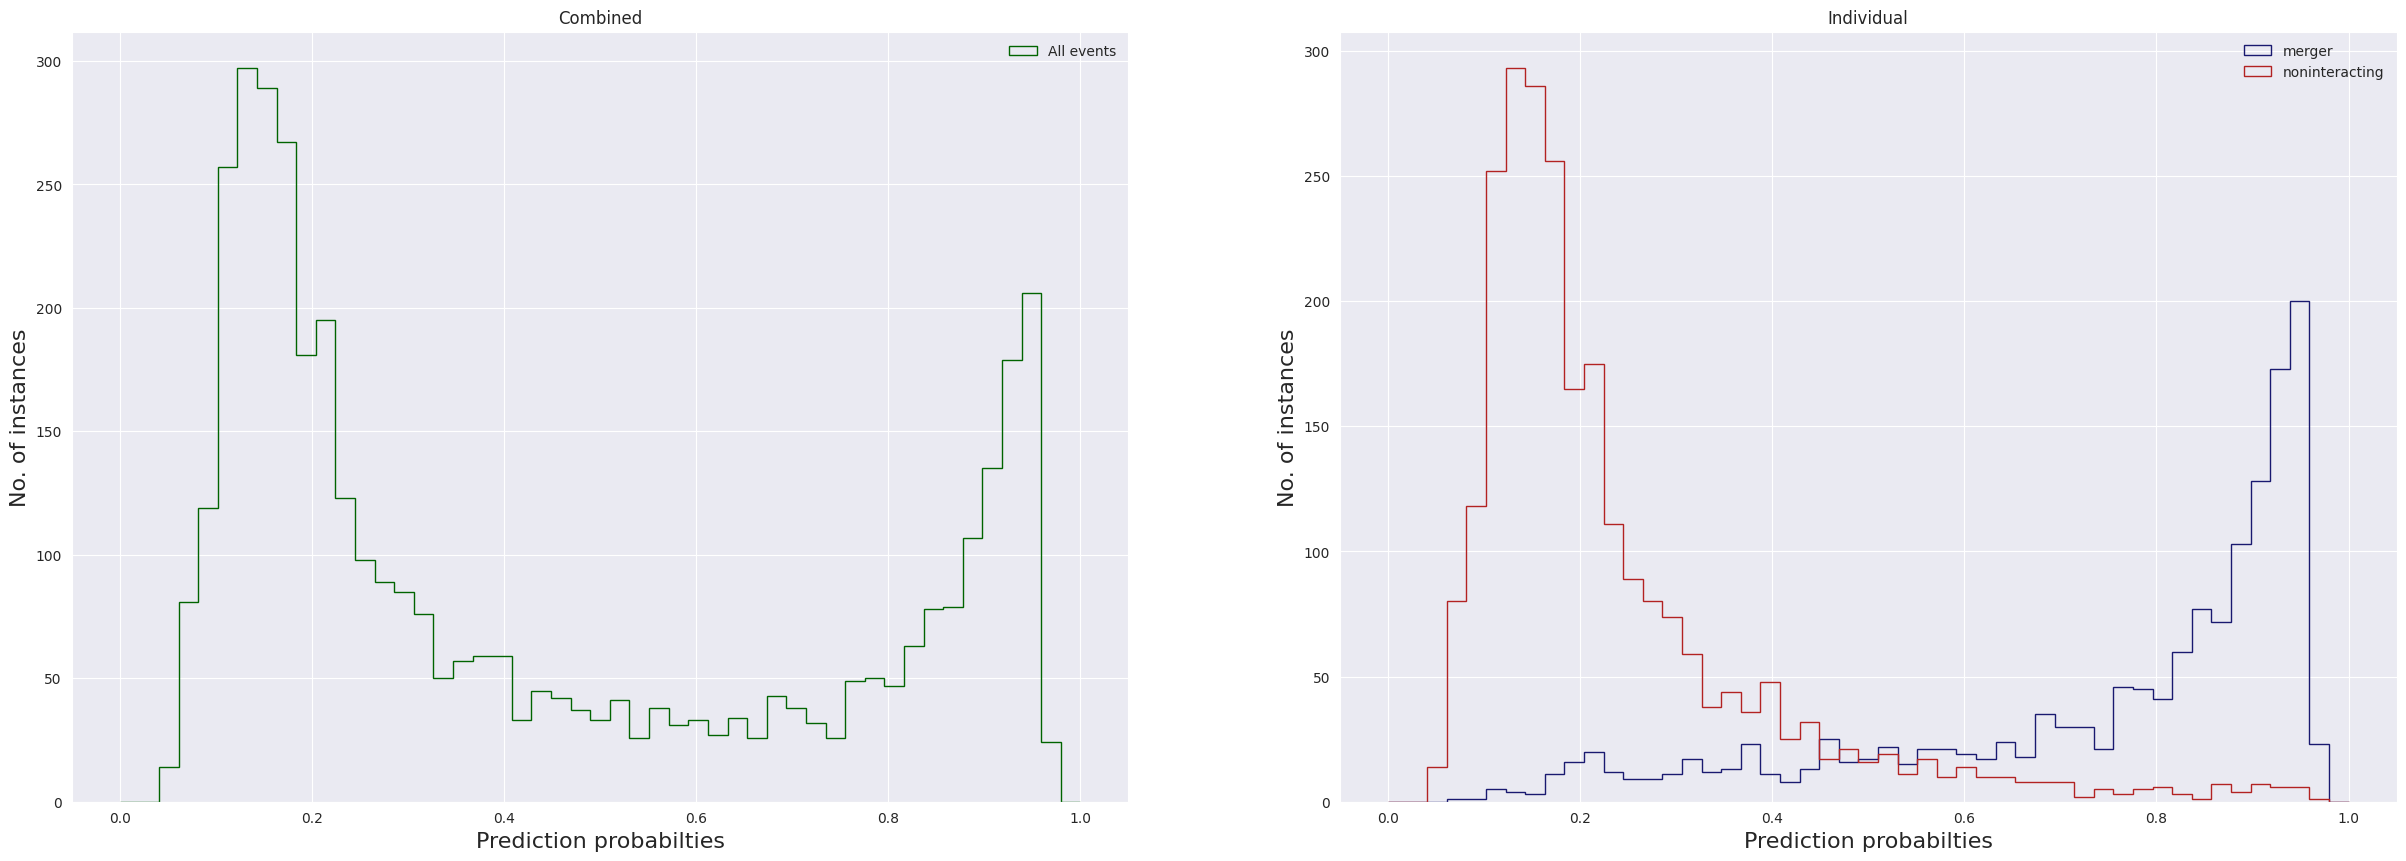

In [146]:
plot_predictions(preds, test)

**Conclusion**: Oversampling of minority class + Undersampling of majority class gives better performance than:

- Not using any over/undersampling technique.
- Using only oversampling of the minority class.

In [23]:
!pip install -U scikit-learn

     |████████████████████████████████| 22.3 MB 2.7 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [20]:
from sklearn.model_selection import GridSearchCV

In [21]:
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support

In [24]:
k_values = [12]
num_trees = 300
history = {}
# over = SMOTE(sampling_strategy=0.8, k_neighbors=k)  # The original ration of minor/major samples was ~0.6.
# under = RandomUnderSampler()
# steps = [('over', over), ('under', under)]
# pipeline = Pipeline(steps=steps)
# train_data_resampled, train_label_resampled = pipeline.fit_resample(train_data, train_labels)

# xgb_clf = xgb.XGBClassifier(num_rounds=num_trees, **params)
# parameters = {"k": [3, 9, 12]}  # Parameters to perform grid search on.
# clf = GridSearchCV(xgb_clf, parameters)
# clf.fit(train_data_resampled, train_label_resampled)


valid = xgb.DMatrix(valid_data, label=valid_labels)
for k in k_values:
  print(f"Start of resampling for {k}")
  over = SMOTE(sampling_strategy=0.8, k_neighbors=k)  # The original ration of minor/major samples was ~0.6.
  under = RandomUnderSampler()
  steps = [('over', over), ('under', under)]
  pipeline = Pipeline(steps=steps)
  train_data_resampled, train_label_resampled = pipeline.fit_resample(train_data, train_labels)
  print(f"Resampling done for {k}")
  print(f"Training started for {k}")
  train = xgb.DMatrix(train_data_resampled, label=train_label_resampled, nthread=-1)
  booster = xgb.train(params, train, num_boost_round=num_trees)
  print(f"Training completed for {k}")
  pred_probs = booster.predict(valid)
  preds = np.rint(pred_probs)

  y_true = valid.get_label()
  y_pred = preds
  history[k] = roc_auc_score(y_true, y_pred), precision_recall_fscore_support(y_true, y_pred)

history

Start of resampling for 12


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Resampling done for 12
Training started for 12
Training completed for 12


{12: (0.881345963975984,
  (array([0.90489237, 0.86980609]),
   array([0.9248    , 0.83789193]),
   array([0.91473788, 0.8535508 ]),
   array([2500, 1499])))}

In [25]:
k_values = [9]
num_trees = 300
history = {}
# over = SMOTE(sampling_strategy=0.8, k_neighbors=k)  # The original ration of minor/major samples was ~0.6.
# under = RandomUnderSampler()
# steps = [('over', over), ('under', under)]
# pipeline = Pipeline(steps=steps)
# train_data_resampled, train_label_resampled = pipeline.fit_resample(train_data, train_labels)

# xgb_clf = xgb.XGBClassifier(num_rounds=num_trees, **params)
# parameters = {"k": [3, 9, 12]}  # Parameters to perform grid search on.
# clf = GridSearchCV(xgb_clf, parameters)
# clf.fit(train_data_resampled, train_label_resampled)


valid = xgb.DMatrix(valid_data, label=valid_labels)
for k in k_values:
  print(f"Start of resampling for {k}")
  over = SMOTE(sampling_strategy=0.8, k_neighbors=k)  # The original ration of minor/major samples was ~0.6.
  under = RandomUnderSampler()
  steps = [('over', over), ('under', under)]
  pipeline = Pipeline(steps=steps)
  train_data_resampled, train_label_resampled = pipeline.fit_resample(train_data, train_labels)
  print(f"Resampling done for {k}")
  print(f"Training started for {k}")
  train = xgb.DMatrix(train_data_resampled, label=train_label_resampled, nthread=-1)
  booster = xgb.train(params, train, num_boost_round=num_trees)
  print(f"Training completed for {k}")
  pred_probs = booster.predict(valid)
  preds = np.rint(pred_probs)

  y_true = valid.get_label()
  y_pred = preds
  history[k] = roc_auc_score(y_true, y_pred), precision_recall_fscore_support(y_true, y_pred)

history

Start of resampling for 9


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Resampling done for 9
Training started for 9
Training completed for 9


{9: (0.8840795196797865,
  (array([0.90568979, 0.87718074]),
   array([0.9296    , 0.83855904]),
   array([0.91748914, 0.8574352 ]),
   array([2500, 1499])))}